<a href="https://colab.research.google.com/github/ucb-datalab/course_materials_fall2024/blob/main/lectures/Lecture20_lab3_cnn/02_neural_nets_with_pytorch.ipynb" target="_blank" rel="nofollow">
    <img src="figs/colab-badge.svg" alt="Open In Colab" />
</a>


# Deep Learning Frameworks

AY 250 (UC Berkeley; 2012-2024)

<div class="alert alert-info">sklearn is not built for deep/complex networks such as required in covnets (as we'll see later on). We must go to specialized software (and potentially specialized hardware)</div>

Almost all frameworks written in low-level C++/C with Python (or other scripting bindings)

### Low-level frameworks

   - Tensorflow (Google) Nov 2015. See https://www.tensorflow.org/api_docs/python/tf
   - pytorch (Python). https://pytorch.org/docs/stable/index.html
   - Theano
   - Caffe (Berkeley)
   - Torch (Lua)
   - CNTK (Microsoft)
   - Chainer
   - PaddlePaddle (Baidu) Aug 2016
   
### High-level frameworks (Python)

   - Keras (atop Tensorflow, Theano) - https://www.tensorflow.org/api_docs/python/tf/keras
   - Skorch - scikit-learn compatible neural network library that wraps PyTorch (https://github.com/skorch-dev/skorch)
   - FastAI: https://docs.fast.ai/
   - PyTorch Lightning (https://github.com/PyTorchLightning/pytorch-lightning)
   
<img src="figs/frameworks.png" width="75%">
Source: https://paperswithcode.com/trends


see also: https://github.com/mbadry1/Top-Deep-Learning

<img src="http://www.asimovinstitute.org/wp-content/uploads/2016/09/neuralnetworks.png">

Source: http://www.asimovinstitute.org/neural-network-zoo/

An example (from Josh's student work): 

<img src="https://github.com/profjsb/deepCR/raw/master/imgs/network.png">

<img src="https://raw.githubusercontent.com/profjsb/deepCR/master/imgs/postage-sm.jpg">

"deepCR: Deep Learning Based Cosmic Ray Removal for Astronomical Images"
https://github.com/profjsb/deepCR

# PyTorch

   - syntax closely resembles Python, making it easy for developers familiar with the language to transition to deep learning.
   - Dynamic Computational Graphs:
Unlike some frameworks that require you to define the entire computation graph upfront (static graphs), PyTorch builds the graph on the fly as you execute your code. This makes debugging easier and allows for more flexibility, especially in research settings where rapid prototyping is crucial.
   - PyTorch leverages the power of GPUs to accelerate computations, making it suitable for training large and complex models efficiently.                                                                           

Let's load up the California housing data as in the previous notebook.

In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn import datasets
from sklearn.preprocessing import StandardScaler  

cal_data = datasets.fetch_california_housing()
X = cal_data['data']   # 8 features 
Y = cal_data['target'] # response (median house price)

half = math.floor(len(Y)/2)
train_X = X[:half]
train_Y = Y[:half]
test_X = X[half:]
test_Y = Y[half:]

scaler = StandardScaler()  

# Don't cheat - fit only on training data
scaler.fit(train_X)  
train_X = scaler.transform(train_X)  

# apply same transformation to test data
test_X = scaler.transform(test_X)

In [2]:
test_X[0,:]

array([ 1.83091342, -1.31085329,  0.84047027, -0.15023587,  0.25295181,
        0.0466981 , -0.83013107,  0.92616793])

In [3]:
num_input_features = train_X.shape[1]
print(f'number of input features = {num_input_features}')

number of input features = 8


In [4]:
import datetime, os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Print torch version
print(torch.__version__)

2.3.1


Let's make a simple neural network in PyTorch, as an MLP with
a few layers.

In [7]:
class NNClf(nn.Module):
    """
    A simple neural network classifier using PyTorch.

    This class defines a neural network with three hidden layers and one output layer.
    It uses ReLU (Rectified Linear Unit) activation function for the hidden layers.

    Attributes:
    -----------
    layer1 : nn.Linear
        The first linear layer which takes input features and maps them to 32 neurons.
    layer2 : nn.Linear
        The second linear layer which takes 32 neurons from the first layer and maps them to another 32 neurons.
    layer3 : nn.Linear
        The third linear layer which takes 32 neurons from the second layer and maps them to 10 neurons.
    output_layer : nn.Linear
        The output layer which takes 10 neurons from the third layer and maps them to a single output.

    Methods:
    --------
    forward(x):
        Defines the forward pass of the neural network. It takes an input tensor `x` and passes it through
        the layers with ReLU activation functions in between, and finally through the output layer.
    """
    def __init__(self, input_features):
        super(NNClf, self).__init__()
        self.layer1 = nn.Linear(input_features, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, 10)
        self.output_layer = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.output_layer(x)
        return x

In [8]:
model = NNClf(num_input_features)
print(model)

NNClf(
  (layer1): Linear(in_features=8, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)


In [9]:
# Convert numpy arrays to PyTorch tensors
train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
train_Y_tensor = torch.tensor(train_Y, dtype=torch.float32).view(-1, 1)
test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
test_Y_tensor = torch.tensor(test_Y, dtype=torch.float32).view(-1, 1)

## Datasets & DataLoaders

"Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples."

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [10]:
# Create DataLoader
train_dataset = TensorDataset(train_X_tensor, train_Y_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [11]:
# Define loss and optimizer

# The criterion is defined as Mean Squared Error (MSE) Loss, which is a common loss function 
# used for regression tasks. It measures the average squared difference between the 
# estimated values and the actual value.
criterion = nn.MSELoss()

# The optimizer is defined as Adam (Adaptive Moment Estimation) optimizer, which is an 
# algorithm for first-order gradient-based optimization of stochastic objective functions. 
# It is configured to optimize the parameters of the model with a learning rate of 0.001.
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
# Training loop
epochs = 50  # Number of epochs to train the model

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    
    # Iterate over batches of data from the training loader
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()  # Clear the gradients of all optimized tensors
        outputs = model(batch_X)  # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, batch_Y)  # Calculate the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)
    print(f"{loss.item():0.3f}", sep=" ", end=" ", flush=True)

0.126 0.128 0.135 0.303 0.048 0.089 0.058 0.203 0.081 0.244 0.256 0.184 0.090 0.159 0.106 0.176 0.225 0.179 0.159 0.307 0.118 0.062 0.118 0.236 0.220 0.163 0.056 0.068 0.164 0.054 0.177 0.236 0.078 0.101 0.062 0.234 0.067 0.059 0.171 0.353 0.109 0.071 0.091 0.204 0.081 0.137 0.176 0.151 0.203 0.081 

In [25]:
# Evaluate the model
model.eval()  # set outselves in evaluation mode
with torch.no_grad():
    predictions = model(test_X_tensor).numpy()

In [26]:
# Calculate MSE
mse = np.mean((predictions - test_Y_tensor.numpy()) ** 2)
print("MSE", mse)

MSE 0.48311388


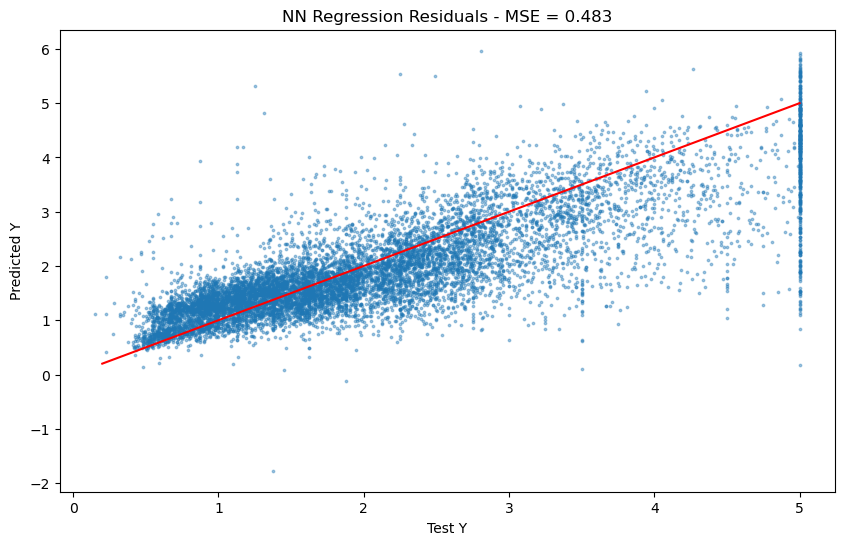

In [27]:
# how well did we do?
import numpy as np

plt.figure(figsize=(10,6))
plt.title("NN Regression Residuals - MSE = %.3f" % mse)
plt.scatter(test_Y_tensor.numpy(), predictions, alpha=0.4, s=3)
plt.xlabel("Test Y")
plt.ylabel("Predicted Y")
plt.plot([0.2, 5], [0.2, 5], c="r")

### A More Complete Example

We want to train and make some decisions of when to stop based on `validation` data. Ultimately, we'd like to see how well our model would do on truly new data (`test`).


In [46]:
train_percentage, valid_percentage, test_percentage = (0.90, 0.05, 0.05)

In [47]:
from sklearn.model_selection import train_test_split

rnd = np.random.RandomState(42)

# make an array with the indices of all the rows in the dataset
ind_arr = np.arange(X.shape[0])
rnd.shuffle(ind_arr)

train_ind, tmp = train_test_split(ind_arr, train_size=train_percentage, random_state=rnd)
valid_ind, test_ind = \
      train_test_split(tmp, train_size=valid_percentage/(valid_percentage + test_percentage), 
                               random_state=rnd)

Let's make sure that we're getting all the indicies

In [48]:
assert np.all(np.array(sorted(list(train_ind) + list(valid_ind) + list(test_ind)))  == \
              sorted(ind_arr))

In [49]:
train_ind.shape, test_ind.shape, valid_ind.shape

((18576,), (1032,), (1032,))

Now let's scale the inputs

In [50]:
scaler = StandardScaler()  

train_X = X[train_ind]
# Don't cheat - fit only on training data
scaler.fit(train_X)  
train_X = scaler.transform(train_X)  

# apply same transformation to test, validation data
test_X = scaler.transform(X[test_ind])
valid_X = scaler.transform(X[valid_ind])

train_y = Y[train_ind] ; test_y = Y[test_ind] ; valid_y = Y[valid_ind]

assert train_y.shape[0] == train_X.shape[0]
assert test_y.shape[0] == test_X.shape[0]
assert valid_y.shape[0] == valid_X.shape[0]

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import datetime
import os

In [52]:
class SimpleNN(nn.Module):
    def __init__(self, num_input_features):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(num_input_features, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, 5)
        self.layer4 = nn.Linear(5, 1)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(5, 1)
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.linear(x)
        return x

In [53]:
# Initialize the model
model = SimpleNN(num_input_features)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [54]:
print(model)

SimpleNN(
  (layer1): Linear(in_features=8, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=5, bias=True)
  (layer4): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
  (linear): Linear(in_features=5, out_features=1, bias=True)
)


In [55]:
# Create directory for results
try:
    os.mkdir('nn_results')
except:
    pass

batch_size = 64
num_epochs = 200

run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
model_path = f'nn_results/ay256_nn_{run_time_string}.pt'

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f'Found GPU at: {torch.cuda.get_device_name(0)}')
else:
    print('GPU device not found')

# Move model to device
model.to(device)

# Prepare data loaders
train_dataset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32))
valid_dataset = TensorDataset(torch.tensor(valid_X, dtype=torch.float32), torch.tensor(valid_y, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

GPU device not found


In [56]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        batch_y = batch_y.view(-1, 1)  # Reshape target to match model output
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch_X, batch_y in valid_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            batch_y = batch_y.view(-1, 1)  # Reshape target to match model output

            outputs = model(batch_X)
            val_loss += criterion(outputs, batch_y).item()
        val_loss /= len(valid_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Val Loss: {val_loss}')

# Save the model
torch.save(model.state_dict(), model_path)

Epoch 1/200, Loss: 0.21562612056732178, Val Loss: 0.5949655210270601
Epoch 2/200, Loss: 0.20769287645816803, Val Loss: 0.4342693213154288
Epoch 3/200, Loss: 0.1927298605442047, Val Loss: 0.39070427680716796
Epoch 4/200, Loss: 0.4280410408973694, Val Loss: 0.3965548136655022
Epoch 5/200, Loss: 0.3611445426940918, Val Loss: 0.36633705917526693
Epoch 6/200, Loss: 0.08753407001495361, Val Loss: 0.35317111497416215
Epoch 7/200, Loss: 0.0892632007598877, Val Loss: 0.35443924630389495
Epoch 8/200, Loss: 0.42893290519714355, Val Loss: 0.3454129507436472
Epoch 9/200, Loss: 0.18830454349517822, Val Loss: 0.3344750956577413
Epoch 10/200, Loss: 0.20184852182865143, Val Loss: 0.3245455223847838
Epoch 11/200, Loss: 0.20047956705093384, Val Loss: 0.317785823608146
Epoch 12/200, Loss: 0.6167957782745361, Val Loss: 0.3122482847641496
Epoch 13/200, Loss: 0.36453068256378174, Val Loss: 0.31150223183281284
Epoch 14/200, Loss: 0.10995399951934814, Val Loss: 0.3043219596147537
Epoch 15/200, Loss: 0.32188460

In [57]:
# Load the best model
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [58]:
# Predict
model.eval()
with torch.no_grad():
    pred_y = model(torch.tensor(test_X, dtype=torch.float32).to(device)).cpu().numpy()
    pred_y = pred_y[:, 0]  # Flatten the predictions

In [59]:
# Calculate MSE
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_y, pred_y)
print("MSE", mse)

MSE 0.25101877805786943


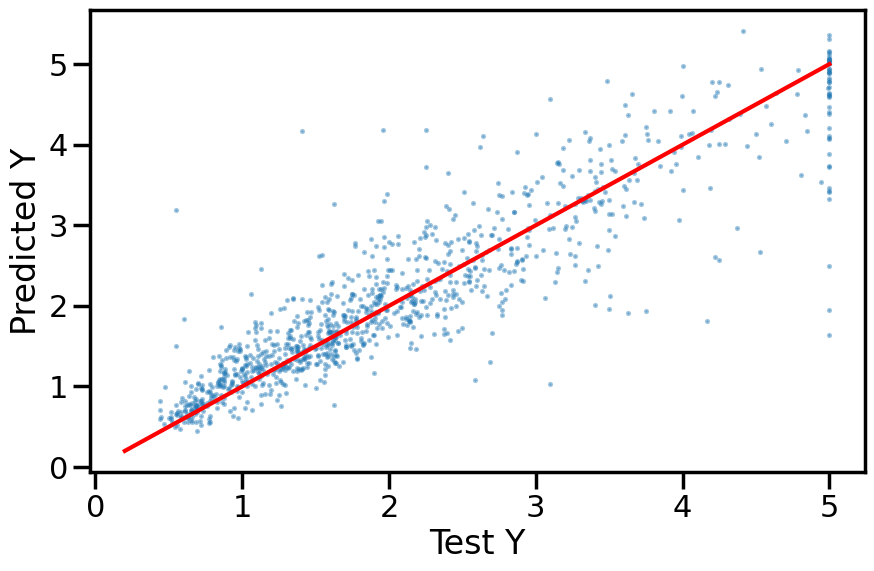

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.scatter(test_y, pred_y, alpha=0.4, s=3)
plt.xlabel("Test Y")
plt.ylabel("Predicted Y")
plt.plot([0.2, 5], [0.2, 5], c="r")

How did we do compared to the validation and training data?

If you're interested in hyperparameter optimization, you could try out Weights & Biases for Keras (https://wandb.ai/site/articles/intro-to-keras-with-weights-biases).

## Aside: Training on a GPU (on Colab)

In [36]:
import torch
if not torch.cuda.is_available():
    print('GPU device not found')
    has_gpu = False
else:
    device_name = torch.cuda.get_device_name(0)
    print('Found GPU at: {}'.format(device_name))
    has_gpu = True

GPU device not found


In [ ]:
#!pip install watermark

In [61]:
%load_ext watermark

In [62]:
%watermark --iversions

pandas    : 2.2.2
torch     : 2.3.1
matplotlib: 3.9.2
seaborn   : 0.13.2
sklearn   : 1.5.1
numpy     : 1.26.4

